# Wind farm optimisation

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point
from matplotlib import patheffects

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import optimisation as opt

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Constraints

In [4]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [5]:
# height = 155 m, 1,000 m <= depth <= 1,500 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"height": 155, "min_depth": 1000, "max_depth": 1500},
)

## Exclusions

In [6]:
caverns, _ = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 901
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 406
Caverns excluded: 54.94%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 359
Caverns excluded: 60.16%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------


In [7]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity [GWh]

In [8]:
# calculate volumes and capacities
caverns = cap.calculate_capacity_dataframe(cavern_df=caverns)

In [9]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         1.165437e+08
working_mass          1.010369e+09
capacity              3.366773e+04
mass_operating_min    6.852969e+08
mass_operating_max    1.695666e+09
dtype: float64

## Power curve [MW] and Weibull wind speed distribution

In [10]:
# extract data for wind farms at 150 m
data = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

In [11]:
# generate Weibull distribution
ref_data = {}
for n in data["Name"]:
    ref_data[n] = {}
    ref_data[n]["wind_speed"] = [0 + 0.01 * n for n in range(3000)]
    ref_data[n]["power_curve"] = []
    ref_data[n][n] = []
    for v in ref_data[n]["wind_speed"]:
        ref_data[n]["power_curve"].append(opt.ref_power_curve(v=v))
        ref_data[n][n].append(
            opt.weibull_probability_distribution(
                v=v,
                k=data[data["Name"] == n][("k", "mean")].iloc[0],
                c=data[data["Name"] == n][("c", "mean")].iloc[0],
            )
        )
    ref_data[n] = pd.DataFrame(ref_data[n])

In [12]:
ref_data = pd.concat(ref_data.values(), axis=1).T.drop_duplicates().T

In [13]:
ref_data.head()

,wind_speed,power_curve,Codling Wind Park,Dublin Array,North Irish Sea Array
0,0.00,0.0,0.000000,0.000000,0.000000
1,0.01,0.0,0.000248,0.000260,0.000079
2,0.02,0.0,0.000479,0.000503,0.000171
3,0.03,0.0,0.000705,0.000739,0.000269
4,0.04,0.0,0.000926,0.000972,0.000371


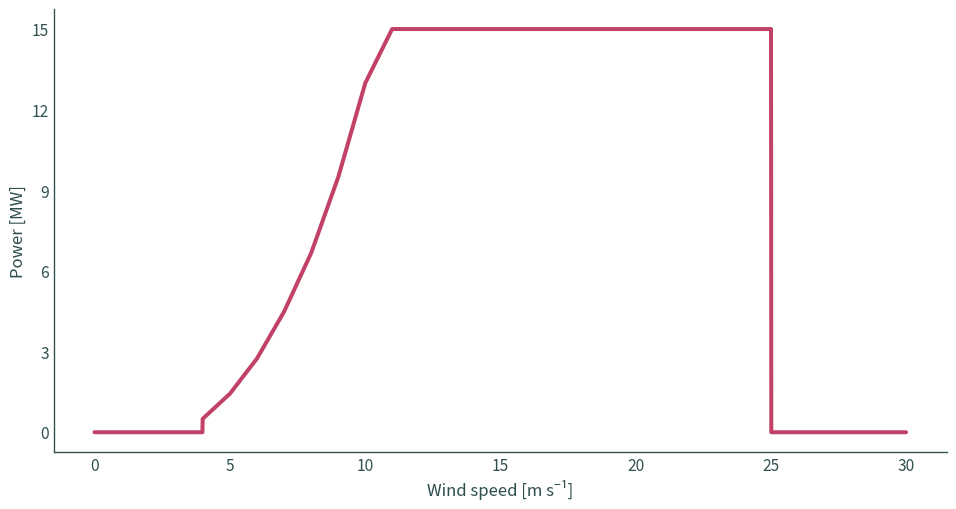

In [14]:
ax = ref_data.plot(
    x="wind_speed",
    y="power_curve",
    ylabel="Power [MW]",
    linewidth=3,
    color=sns.color_palette("flare", 256)[127],
    figsize=(12, 6),
    legend=False,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel("Power [MW]")
plt.yticks([3 * n for n in range(6)])
sns.despine()

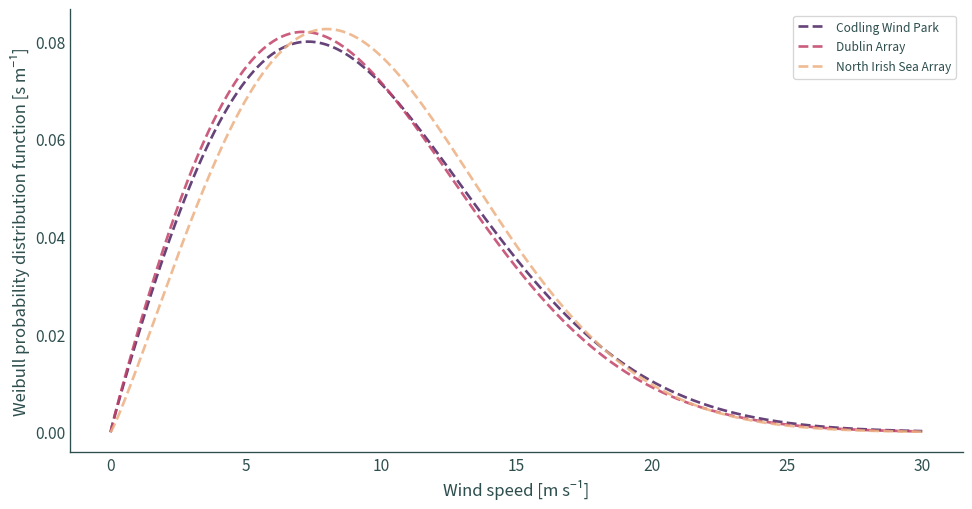

In [15]:
ax = ref_data.drop(columns=["power_curve"]).plot(
    x="wind_speed",
    cmap="flare_r",
    figsize=(12, 6),
    linestyle="dashed",
    linewidth=2,
    alpha=0.85,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel(
    "Weibull probability distribution function "
    "[s m\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]"
)
sns.despine()

## Annual energy production [MWh]

In [16]:
# max wind farm capacity
data["cap"] = [1300, 824, 500]

In [17]:
# number of 15 MW turbines, rounded down to the nearest integer
data["n_turbines"] = opt.number_of_turbines(owf_cap=data["cap"])

In [18]:
aep = []
for n in data["Name"]:
    aepwt = opt.annual_energy_production(
        n_turbines=data[data["Name"] == n]["n_turbines"].iloc[0],
        k=data[data["Name"] == n][("k", "mean")].iloc[0],
        c=data[data["Name"] == n][("c", "mean")].iloc[0],
    )
    aep.append(aepwt)

In [19]:
aep = pd.DataFrame(aep)
aep.columns = ["AEP", "integral", "abserr"]

In [20]:
data = pd.concat([data, aep], axis=1)

## Annual hydrogen production [kg]

In [21]:
data["AHP"] = opt.annual_hydrogen_production(aep=data["AEP"])

## AHP as a proportion of the total working mass

In [22]:
data["AHP_frac"] = data["AHP"] / caverns[["working_mass"]].sum().iloc[0]

## Number of caverns required based on cumulative working mass and AHP

In [23]:
working_mass_cumsum_1 = (
    caverns.sort_values("working_mass", ascending=False)
    .reset_index()[["working_mass", "capacity"]]
    .cumsum()
)

In [24]:
working_mass_cumsum_2 = (
    caverns.sort_values("working_mass")
    .reset_index()[["working_mass", "capacity"]]
    .cumsum()
)

In [25]:
caverns_low = []
caverns_high = []
cap_max = []
for x in range(len(data)):
    print(data["Name"].iloc[x])
    print(f"Working mass [kg]: {(data['AHP'].iloc[x]):.6E}")
    caverns_low.append(
        working_mass_cumsum_1.loc[
            working_mass_cumsum_1["working_mass"] >= data["AHP"].iloc[x]
        ]
        .head(1)
        .index[0]
        + 1
    )
    caverns_high.append(
        working_mass_cumsum_2.loc[
            working_mass_cumsum_2["working_mass"] >= data["AHP"].iloc[x]
        ]
        .head(1)
        .index[0]
        + 1
    )
    print(f"Number of caverns required: {caverns_low[x]}–{caverns_high[x]}")
    cap_max.append(
        max(
            working_mass_cumsum_1.loc[
                working_mass_cumsum_1["working_mass"] >= data["AHP"].iloc[x]
            ]
            .head(1)["capacity"]
            .values[0],
            working_mass_cumsum_2.loc[
                working_mass_cumsum_2["working_mass"] >= data["AHP"].iloc[x]
            ]
            .head(1)["capacity"]
            .values[0],
        )
    )
    print(f"Capacity (approx.) [GWh]: {(cap_max[x]):.2f}")
    print("-" * 50)

Codling Wind Park
Working mass [kg]: 9.985922E+07
Number of caverns required: 31–41
Capacity (approx.) [GWh]: 3381.42
--------------------------------------------------
Dublin Array
Working mass [kg]: 6.115752E+07
Number of caverns required: 19–25
Capacity (approx.) [GWh]: 2051.07
--------------------------------------------------
North Irish Sea Array
Working mass [kg]: 4.036357E+07
Number of caverns required: 13–17
Capacity (approx.) [GWh]: 1407.67
--------------------------------------------------


In [26]:
# total number of caverns
print(
    f"Total number of caverns required: {sum(caverns_low)}–{sum(caverns_high)}"
)

Total number of caverns required: 63–83


In [27]:
# number of caverns as a percentage of the total available caverns
print(
    "Number of caverns required as a percentage of all available caverns:",
    f"{(sum(caverns_low) / len(caverns) * 100):.2f}–"
    + f"{(sum(caverns_high) / len(caverns) * 100):.2f}%",
)

Number of caverns required as a percentage of all available caverns: 17.65–23.25%


In [28]:
# total capacity
print(f"Total capacity (approx.): {sum(cap_max):.2f} GWh")

Total capacity (approx.): 6840.17 GWh


In [29]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
print(
    "Energy capacity as a percentage of Ireland's electricity demand in 2050:",
    f"{(sum(cap_max) / 1000 / 122 * 100):.2f}–"
    + f"{(sum(cap_max) / 1000 / 84 * 100):.2f}%",
)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 5.61–8.14%


## Calculate distance between caverns and the wind farms and injection point [km]

In [30]:
wind_farms["Name_"] = wind_farms["Name"].str.split(expand=True)[0]
wind_farms = wind_farms.dissolve("Name_").reset_index()

In [31]:
# Dublin Port coordinates (Dinh et al. - injection point)
injection_point = gpd.GeoSeries(
    [Point(-(6 + 12 / 60), 53 + 21 / 60)], crs=4326
)
injection_point = injection_point.to_crs(rd.CRS)

In [32]:
distance_ip = []
for j in range(len(caverns)):
    distance_ip.append(
        injection_point.distance(
            caverns.iloc[[j]]["geometry"], align=False
        ).values[0]
        / 1000
    )
caverns["distance_ip"] = distance_ip

In [33]:
distance_wf = {}
for i in range(len(wind_farms)):
    distance_wf[wind_farms["Name_"][i]] = []
    for j in range(len(caverns)):
        distance_wf[wind_farms["Name_"][i]].append(
            (
                wind_farms.iloc[[i]]
                .distance(caverns.iloc[[j]]["geometry"], align=False)
                .values[0]
                / 1000
                + caverns.iloc[[j]]["distance_ip"].values[0]
            )
        )
    caverns[f"dist_{wind_farms['Name_'][i]}"] = distance_wf[
        wind_farms["Name_"][i]
    ]

## CAPEX for pipeline [€ km⁻¹]

In [34]:
# calculate electrolyser capacity
data["E_cap"] = opt.electrolyser_capacity(n_turbines=data["n_turbines"])

In [35]:
data["CAPEX"] = opt.capex_pipeline(e_cap=data["E_cap"])

In [36]:
data

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",cap,n_turbines,AEP,integral,abserr,AHP,AHP_frac,E_cap,CAPEX
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95,1300,86,5.668353e+06,8.360106,4.565276e-07,9.985922e+07,0.098834,1079,1.462152e+06
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95,824,54,3.471511e+06,8.154141,4.675453e-07,6.115752e+07,0.060530,677,1.212022e+06
2,North Irish Sea Array,10.4,11.1,10.806250,2.1,2.2,2.12,500,33,2.291175e+06,8.806387,4.437917e-07,4.036357e+07,0.039949,414,1.037363e+06


## LCOT for pipeline [€ kg⁻¹]

In [37]:
for wf in list(wind_farms["Name_"]):
    caverns[f"LCOT_{wf}"] = opt.lcot_pipeline(
        capex=data[data["Name"].str.contains(wf)]["CAPEX"].values[0],
        transmission_distance=caverns[f"dist_{wf}"],
        ahp=data[data["Name"].str.contains(wf)]["AHP"].values[0],
    )

In [38]:
caverns[
    [
        "cavern_depth",
        "working_mass",
        "capacity",
        "distance_ip",
        "dist_Codling",
        "dist_Dublin",
        "dist_North",
        "LCOT_Codling",
        "LCOT_Dublin",
        "LCOT_North",
    ]
].describe()

,cavern_depth,working_mass,capacity,distance_ip,dist_Codling,dist_Dublin,dist_North,LCOT_Codling,LCOT_Dublin,LCOT_North
count,357.000000,3.570000e+02,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,1230.733769,2.830165e+06,94.307377,30.107326,58.508685,44.324537,50.611314,0.070182,0.072059,0.106629
std,141.546802,2.406478e+05,8.018921,6.869687,12.173576,13.234438,8.076779,0.014542,0.021397,0.016934
min,1000.558475,2.422773e+06,80.732188,14.294115,33.090298,19.586181,37.904683,0.039820,0.032063,0.079987
25%,1103.648373,2.614863e+06,87.133031,23.776583,52.805023,34.364489,41.856734,0.063369,0.055956,0.088274
50%,1225.320306,2.829205e+06,94.275414,32.239103,60.992121,48.468441,51.692175,0.073149,0.078759,0.108895
75%,1347.560593,3.032095e+06,101.036147,35.459512,66.912492,53.762811,57.795720,0.080221,0.087319,0.121692
max,1499.035241,3.267678e+06,108.886301,42.751238,80.403976,69.418567,64.288068,0.096337,0.112630,0.135305


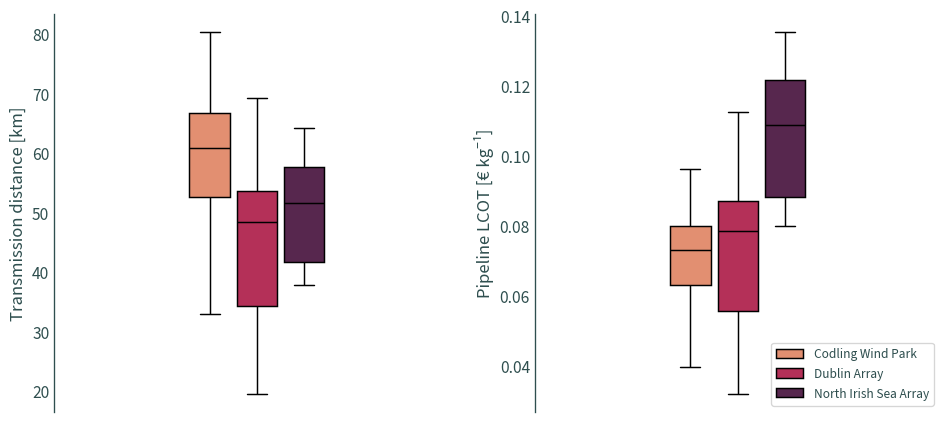

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
sns.boxplot(
    caverns.filter(like="dist_")
    .set_axis(
        list(data["Name"]), axis=1
    )
    .melt(),
    y="value",
    hue="variable",
    palette="rocket_r",
    width=0.35,
    ax=axes[0],
    legend=False,
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[0].set_ylabel("Transmission distance [km]")
sns.boxplot(
    caverns.filter(like="LCOT_")
    .set_axis(
        list(data["Name"]), axis=1
    )
    .melt(),
    y="value",
    hue="variable",
    palette="rocket_r",
    width=0.35,
    ax=axes[1],
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[1].set_ylabel("Pipeline LCOT [€ kg⁻¹]")
axes[1].legend(loc="lower right")
sns.despine(bottom=True)
plt.tight_layout()
plt.show()

## Maps

In [40]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [41]:
def plot_map_facet(cavern_df, classes, fontsize=11.5):
    """Helper function for plotting LCOT facet maps"""
    fig1 = plt.figure(figsize=(11, 11.75))
    xmin_, ymin_, xmax_, ymax_ = cavern_df.total_bounds
    colours = [
        int(n * 255 / (len(classes) - 2)) for n in range(len(classes) - 1)
    ]
    legend_handles = []
    classes = sorted(classes)

    for a, wf1 in enumerate(list(wind_farms["Name_"])):
        ax1 = fig1.add_subplot(2, 2, a + 1, projection=ccrs.epsg(rd.CRS))
        gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
            ax=ax1,
            scheme="UserDefined",
            classification_kwds={"bins": classes[1:]},
            column=f"LCOT_{wf1}",
            zorder=2,
            marker=".",
            cmap="flare",
            markersize=8,
        )
        shape.plot(
            ax=ax1, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
        )
        cx.add_basemap(
            ax1,
            crs=rd.CRS,
            source=cx.providers.CartoDB.VoyagerNoLabels,
            attribution=False,
        )
        if a in (0, 2):
            draw_labels = {"bottom": "x", "left": "y"}
        else:
            draw_labels = {"bottom": "x"}
        ax1.gridlines(
            draw_labels=draw_labels,
            color="none",
            xlabel_style={"fontsize": fontsize},
            ylabel_style={"fontsize": fontsize},
            xformatter=LongitudeFormatter(number_format=".2f"),
            yformatter=LatitudeFormatter(number_format=".2f"),
        )
        if a == 2:
            ax1.add_artist(
                ScaleBar(
                    1,
                    box_alpha=0,
                    location="lower right",
                    color="darkslategrey",
                    font_properties={"size": fontsize},
                )
            )
        plt.xlim(xmin_ - 1000, xmax_ + 1000)
        plt.ylim(ymin_ - 1000, ymax_ + 1000)
        ax1.set_title(list(data["Name"])[a])

    for n1, c in enumerate(colours):
        if n1 == 0:
            label = f"< {classes[1:][n1]}"
        elif n1 == len(colours) - 1:
            label = f"≥ {classes[1:][-2]}"
        else:
            label = f"{classes[1:][n1 - 1]:.2f}–{classes[1:][n1]:.2f}"
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[c], label=label
            )
        )
        plt.legend(
            loc="lower right",
            bbox_to_anchor=(1, 0.075),
            handles=legend_handles,
            title="Pipeline LCOT [€ kg⁻¹]",
            fontsize=fontsize,
            title_fontsize=fontsize,
        )
    plt.tight_layout()
    plt.show()

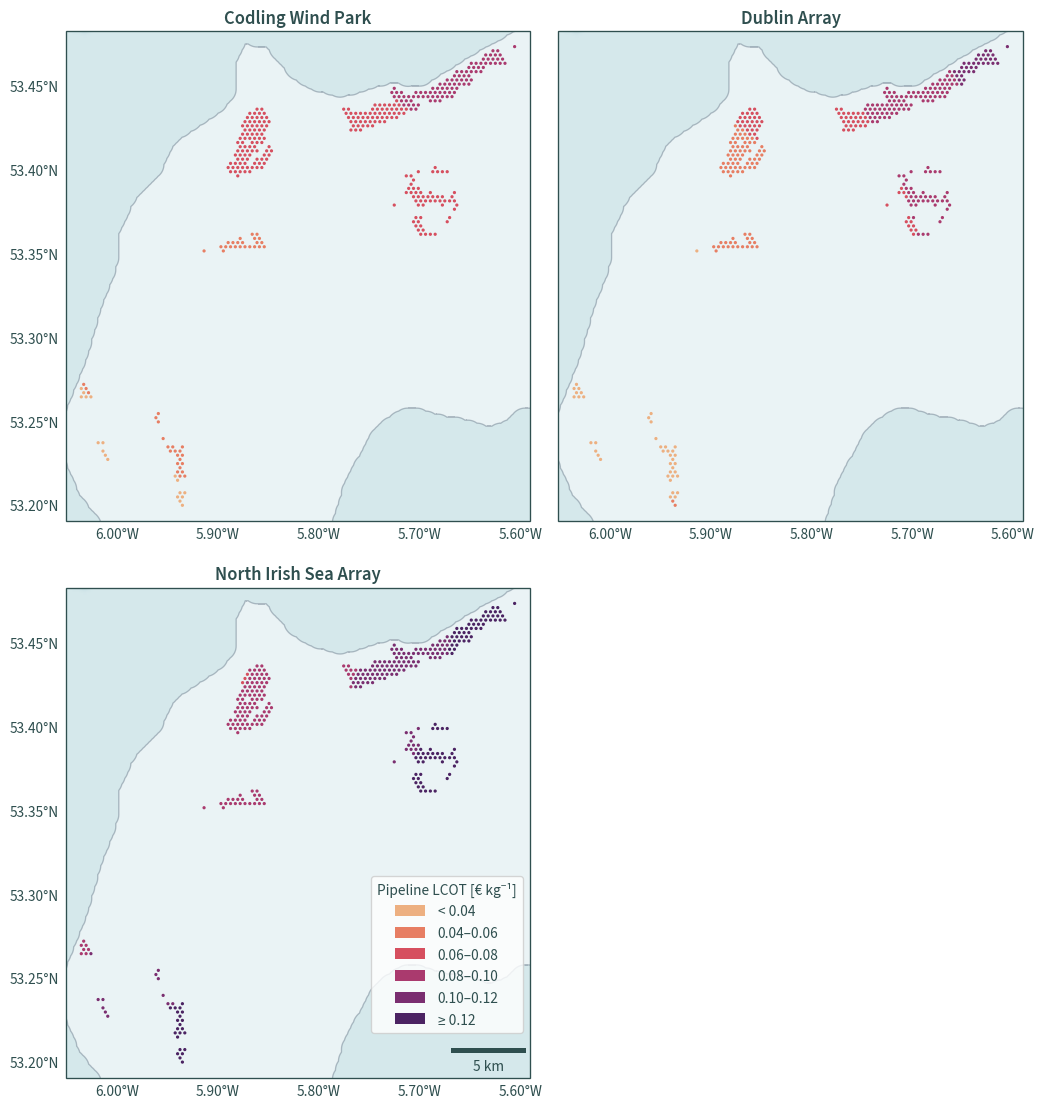

In [42]:
plot_map_facet(caverns, [0] + list(np.arange(0.04, 0.121, step=0.02)) + [0.16])

In [101]:
def plot_map_extent(cavern_df, fontsize=11.5):
    """Helper function for plotting extent map"""
    xmin_, _, xmax_, _ = extent.total_bounds
    _, ymin_, _, ymax_ = wind_farms.total_bounds
    plt.figure(figsize=(6, 6))
    ax2 = plt.axes(projection=ccrs.epsg(rd.CRS))
    shape.plot(
        ax=ax2, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
    )
    gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
        ax=ax2,
        marker=".",
        markersize=2.5,
        color="firebrick"
    )
    gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).dissolve().buffer(1000).envelope.boundary.plot(
        ax=ax2,
        color="darkslategrey"
    )
    wind_farms.plot(ax=ax2, facecolor="none", hatch="///", edgecolor="royalblue")
    plt.xlim(xmin_ - 19500, xmax_ + 500)
    plt.ylim(ymin_ - 3000, ymax_ + 3000)
    cx.add_basemap(
        ax2,
        crs=rd.CRS,
        zoom=9,
        source=cx.providers.CartoDB.Voyager
    )
    legend_handles = [mpatches.Patch(
        facecolor="none",
        hatch="///",
        edgecolor="royalblue"),
        ]
    map_labels = zip(
        zip(wind_farms.centroid.x, wind_farms.centroid.y), data["Name"]
    )
    for xy, lab in map_labels:
        ax2.annotate(text=lab, xy=xy, path_effects=[patheffects.withStroke(linewidth=3,
                                                        foreground="w")])
    ax2.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey"
        )
    )
    plt.tight_layout()
    plt.show()

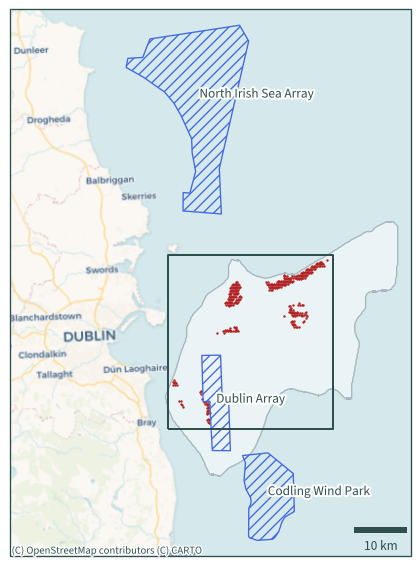

In [102]:
plot_map_extent(caverns)